## Employee Visas

In [1]:
### You can go back to the colab notebook, to realise there any many things to add. 
### The Colab notebook, still has to be put into the pipeline of things. 

In [14]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
import sovai as sov
sov.basic_auth("your_email@example.com", "your_password")

True

#### Processed Dataset

In [189]:
df_visa = sov.data("visas/h1b", start_date="2010-01-01", tickers=["MSFT","TSLA", "AAPL","META"], limit=1000000)

In [190]:
df_visa_ri = df_visa.reset_index()
# df_aapl = df_visa_ri[df_visa_ri["ticker"]=="AAPL"]


In [191]:
import pandas as pd


# Dictionary mapping state names to their abbreviations
state_abbreviations = {
    'Alabama': 'AL', 'Alaska': 'AK', 'Arizona': 'AZ', 'Arkansas': 'AR', 'California': 'CA',
    'Colorado': 'CO', 'Connecticut': 'CT', 'Delaware': 'DE', 'Florida': 'FL', 'Georgia': 'GA',
    'Hawaii': 'HI', 'Idaho': 'ID', 'Illinois': 'IL', 'Indiana': 'IN', 'Iowa': 'IA',
    'Kansas': 'KS', 'Kentucky': 'KY', 'Louisiana': 'LA', 'Maine': 'ME', 'Maryland': 'MD',
    'Massachusetts': 'MA', 'Michigan': 'MI', 'Minnesota': 'MN', 'Mississippi': 'MS', 'Missouri': 'MO',
    'Montana': 'MT', 'Nebraska': 'NE', 'Nevada': 'NV', 'New Hampshire': 'NH', 'New Jersey': 'NJ',
    'New Mexico': 'NM', 'New York': 'NY', 'North Carolina': 'NC', 'North Dakota': 'ND', 'Ohio': 'OH',
    'Oklahoma': 'OK', 'Oregon': 'OR', 'Pennsylvania': 'PA', 'Rhode Island': 'RI', 'South Carolina': 'SC',
    'South Dakota': 'SD', 'Tennessee': 'TN', 'Texas': 'TX', 'Utah': 'UT', 'Vermont': 'VT',
    'Virginia': 'VA', 'Washington': 'WA', 'West Virginia': 'WV', 'Wisconsin': 'WI', 'Wyoming': 'WY',
    'District of Columbia': 'DC', 'Puerto Rico': 'PR'
}

# Invert the dictionary to map from abbreviations to names and ensure all keys and values are upper case
abbrev_to_state = {v.upper(): k for k, v in state_abbreviations.items()}
state_to_abbrev = {k.upper(): v for k, v in state_abbreviations.items()}

# Function to normalize state names to abbreviations in uppercase
def normalize_state(state):
    state = state.strip().upper()
    if state in state_to_abbrev:
        return state_to_abbrev[state]
    elif state in abbrev_to_state:
        return state
    return state  # Returning the original string if not found; can be replaced with other default behavior if needed

df_visa_ri["worksite_state"] = df_visa_ri["worksite_state"].apply(normalize_state)


In [193]:
df_visa_ri["worksite_state"].value_counts()

WA    62528
CA    40731
TX     6837
GA     1580
NY     1151
NC     1117
NV      782
MA      743
NJ      567
FL      437
OR      335
IL      335
ND      284
PA      217
CO      151
MN      137
UT      112
AZ      100
VA       95
MD       58
AR       47
WI       46
MI       44
TN       37
IN       24
LA       17
MO       17
DC       16
CT        6
OH        5
KS        4
PR        2
ME        1
AK        1
Name: worksite_state, dtype: int64

In [ ]:
### worksite_state has to be normalized!!

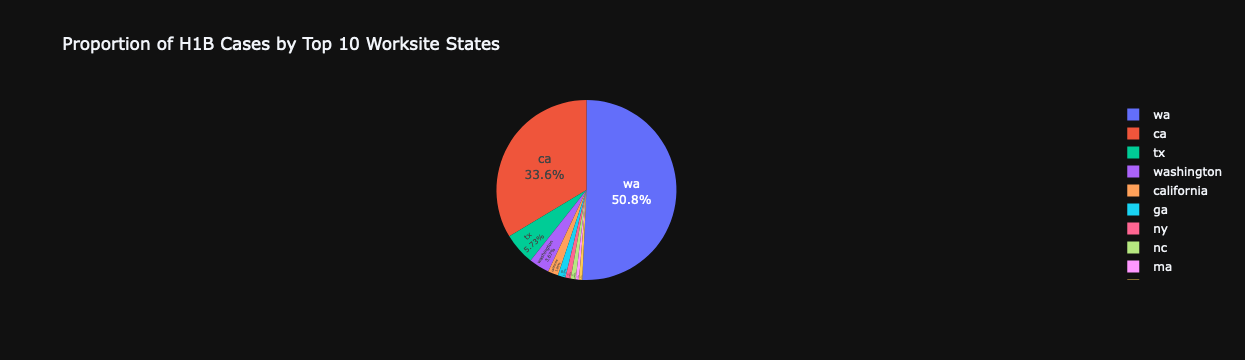

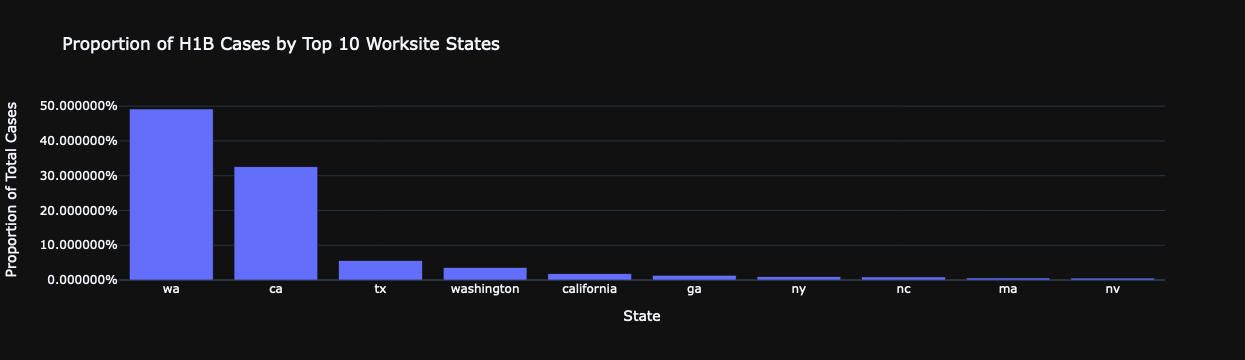

In [175]:
top_states = df_visa_ri.groupby("worksite_state")['ticker'].count().nlargest(10)

# Step 2: Calculate total cases and proportions
total_cases = df_visa_ri['ticker'].count()
top_states_proportions = top_states / total_cases
top_states_proportions = top_states_proportions.reset_index()
top_states_proportions.columns = ['worksite_state', 'proportion']

# Step 3: Create a pie chart
fig = px.pie(top_states_proportions, values='proportion', names='worksite_state', title='Proportion of H1B Cases by Top 10 Worksite States')
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.show()

# Or create a bar chart
fig = px.bar(top_states_proportions, x='worksite_state', y='proportion',
             title='Proportion of H1B Cases by Top 10 Worksite States',
             labels={'proportion': 'Proportion of Total Cases', 'worksite_state': 'State'})
fig.update_layout(yaxis_tickformat='%', xaxis_title="State", yaxis_title="Proportion of Total Cases")
fig.show()

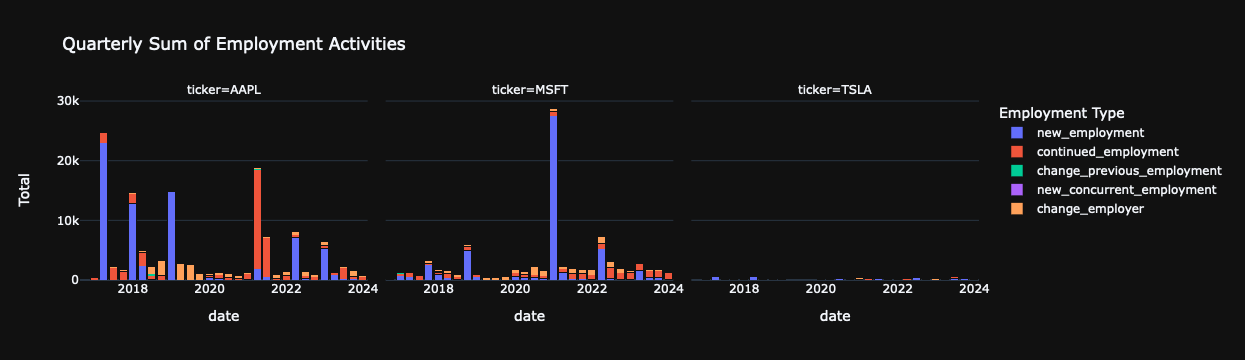

In [156]:
# Group by ticker and resample quarterly, summing up the specified columns
df_resampled = df_visa.groupby('ticker').resample('Q', level='date').agg({
    'new_employment': 'sum',
    'continued_employment': 'sum',
    'change_previous_employment': 'sum',
    'new_concurrent_employment': 'sum',
    'change_employer': 'sum'
}).reset_index()

df_resampled = df_resampled[df_resampled['date'] >= pd.Timestamp('2016-09-01')]


# Reshape the DataFrame from wide to long format for easier plotting with Plotly
df_long = df_resampled.melt(id_vars=['ticker', 'date'], var_name='Employment Type', value_name='Total')

# Create the stacked bar chart
fig = px.bar(df_long, 
             x='date', 
             y='Total', 
             color='Employment Type', 
             barmode='stack',
             facet_col='ticker',  # Use this if you want separate charts for each ticker
             title='Quarterly Sum of Employment Activities')

# Show the plot
fig.show()

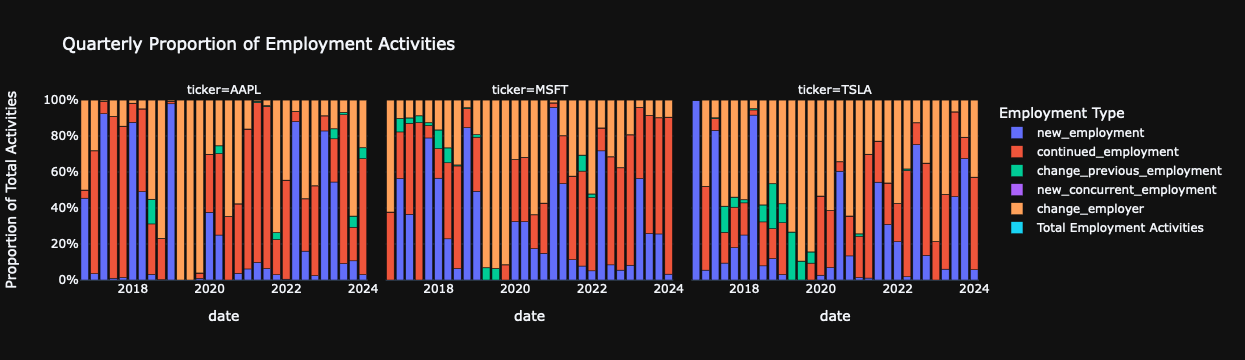

In [155]:
# Group by ticker and resample quarterly, summing up the specified columns
df_resampled = df_visa.groupby('ticker').resample('Q', level='date').agg({
    'new_employment': 'sum',
    'continued_employment': 'sum',
    'change_previous_employment': 'sum',
    'new_concurrent_employment': 'sum',
    'change_employer': 'sum'
}).reset_index()

# Calculate the total of all types of employment for each period to find proportions
df_resampled['Total Employment Activities'] = df_resampled[['new_employment', 'continued_employment', 'change_previous_employment', 'new_concurrent_employment', 'change_employer']].sum(axis=1)

# Calculate the proportion of each type of employment
for col in ['new_employment', 'continued_employment', 'change_previous_employment', 'new_concurrent_employment', 'change_employer']:
    df_resampled[col] = df_resampled[col] / df_resampled['Total Employment Activities']

# Filter data to start from September 2016
df_resampled = df_resampled[df_resampled['date'] >= pd.Timestamp('2016-09-01')]


# Reshape the DataFrame from wide to long format for easier plotting with Plotly
df_long = df_resampled.melt(id_vars=['ticker', 'date'], var_name='Employment Type', value_name='Proportion')

# Create the stacked bar chart
fig = px.bar(df_long, 
             x='date', 
             y='Proportion', 
             color='Employment Type', 
             barmode='relative',  # This ensures the bars are stacked showing the relative proportions
             facet_col='ticker',  # Use this if you want separate charts for each ticker
             title='Quarterly Proportion of Employment Activities',
             labels={'Proportion': 'Proportion of Total Activities'},
             category_orders={"Employment Type": ["new_employment", "continued_employment", "change_previous_employment", "new_concurrent_employment", "change_employer"]})  # Optional: Orders the stack sequence

# Adjust y-axis to show proportions from 0 to 1
fig.update_layout(yaxis=dict(tickformat='.0%', range=[0, 1]))

# Show the plot
fig.show()


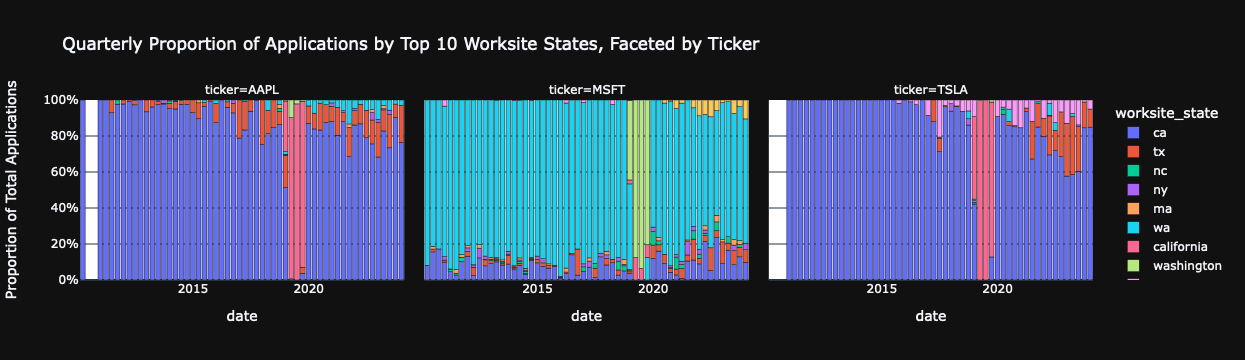

In [180]:
import pandas as pd
import plotly.express as px

# Assuming df_visa is your DataFrame and includes 'date', 'case_status', and 'worksite_state'
# Convert 'date' column to datetime if it's not already
# df_visa['date'] = pd.to_datetime(df_visa['date'])
# Identify the top 10 states based on total application volume
top_states = df_visa['worksite_state'].value_counts().nlargest(10).index

# Filter the DataFrame for only the top 10 states
df_visa_filtered = df_visa[df_visa['worksite_state'].isin(top_states)]

# Group by state and ticker, resample quarterly
df_resampled = df_visa_filtered.groupby(['ticker', 'worksite_state', pd.Grouper(level='date', freq='Q')]).size().reset_index(name='counts')

# Calculate the total applications per ticker and date
total_counts = df_resampled.groupby(['ticker', 'date'])['counts'].sum().reset_index(name='total_counts')

# Merge back to calculate proportions
df_resampled = df_resampled.merge(total_counts, on=['ticker', 'date'])
df_resampled['proportion'] = df_resampled['counts'] / df_resampled['total_counts']

# Reshape the DataFrame from wide to long format for easier plotting with Plotly
df_long = df_resampled.melt(id_vars=['worksite_state', 'date', 'ticker'], value_vars=['proportion'], var_name='Metric', value_name='Value')

# Create the stacked bar chart, using faceting by ticker
fig = px.bar(df_long, 
             x='date', 
             y='Value', 
             color='worksite_state',  # Colors represent different worksite states
             barmode='relative',  # This ensures the bars are stacked showing the relative proportions
             facet_col='ticker',  # Faceting by ticker
             title='Quarterly Proportion of Applications by Top 10 Worksite States, Faceted by Ticker',
             labels={'Value': 'Proportion of Total Applications'},
             category_orders={"Metric": ["proportion"]})  # Optional: Orders the stack sequence

# Adjust y-axis to show proportions from 0 to 1
fig.update_layout(yaxis=dict(tickformat='.0%', range=[0, 1]))

# Optional: Adjust layout if faceting
fig.update_layout(
    autosize=True,
    plot_bgcolor='white'
)

# Show the plot
fig.show()

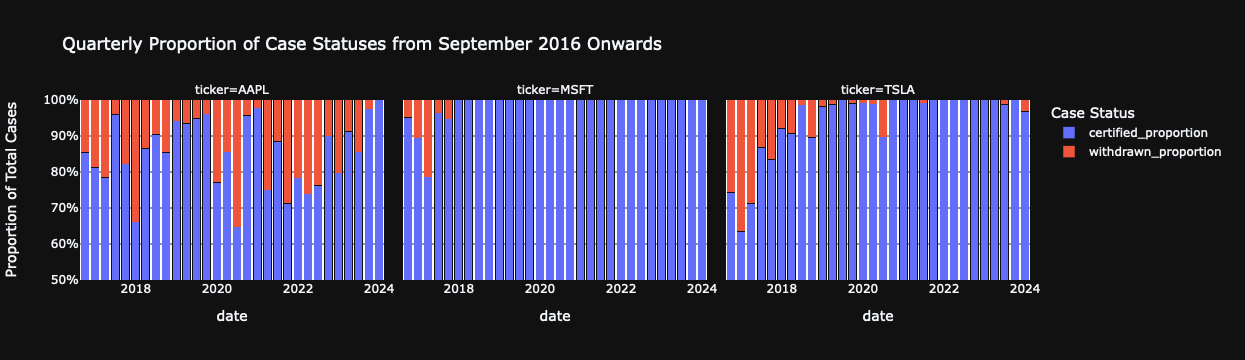

In [169]:
import pandas as pd
import plotly.express as px

# Assuming df_visa is your DataFrame and it includes 'date' and 'case_status' columns
# Convert 'date' column to datetime if it's not already
# df_visa['date'] = pd.to_datetime(df_visa['date'])

# Step 1: Adjust the case status
# Step 1: Adjust the case status
df_visa['case_status'] = df_visa['case_status'].apply(lambda x: 'withdrawn' if x != 'certified' else 'certified')

# Step 2: Group by ticker and resample quarterly, counting the status occurrences
df_resampled = df_visa.groupby(['ticker', pd.Grouper(level='date', freq='Q')])['case_status'].value_counts().unstack(fill_value=0).reset_index()

# Filter data to start from September 2016
df_resampled = df_resampled[df_resampled['date'] >= pd.Timestamp('2016-09-01')]

# Calculate the total of case statuses for each period
df_resampled['total_cases'] = df_resampled['certified'] + df_resampled['withdrawn']

# Calculate the proportion of each case status
df_resampled['certified_proportion'] = df_resampled['certified'] / df_resampled['total_cases']
df_resampled['withdrawn_proportion'] = df_resampled['withdrawn'] / df_resampled['total_cases']

# Reshape the DataFrame from wide to long format for easier plotting with Plotly
df_long = df_resampled.melt(id_vars=['ticker', 'date'], value_vars=['certified_proportion', 'withdrawn_proportion'], var_name='Case Status', value_name='Proportion')

# Create the stacked bar chart, using faceting by ticker if necessary
fig = px.bar(df_long, 
             x='date', 
             y='Proportion', 
             color='Case Status', 
             barmode='stack',  # This ensures the bars are stacked showing the relative proportions
             facet_col='ticker',  # Faceting by ticker
             title='Quarterly Proportion of Case Statuses from September 2016 Onwards',
             labels={'Proportion': 'Proportion of Total Cases'},
             category_orders={"Case Status": ["certified_proportion", "withdrawn_proportion"]})  # Optional: Orders the stack sequence

# Adjust y-axis to show proportions from 0 to 1
fig.update_layout(yaxis=dict(tickformat='.0%', range=[0.5, 1]))

# Optional: Adjust layout if faceting
fig.update_layout(
    autosize=True,
    # width=1000,
    # height=600,
    plot_bgcolor='white'
)

# Show the plot
fig.show()


In [162]:
import pandas as pd
import plotly.express as px

# Assuming df_visa is your DataFrame and it has the specified employment-related columns and 'date' column
# Convert 'date' column to datetime if it's not already
# df_visa['date'] = pd.to_datetime(df_visa['date'])

# Step 1: Adjust the case status
df_visa['case_status'] = df_visa['case_status'].apply(lambda x: 'withdrawn' if x != 'certified' else 'certified')

# Step 2: Group by ticker and resample quarterly, summing up the specified columns
df_resampled = df_visa.groupby('ticker').resample('Q', level='date').agg({
    'case_status': 'count'
}).reset_index()


# Filter data to start from September 2016
df_resampled = df_resampled[df_resampled.index.get_level_values('date') >= pd.Timestamp('2016-09-01')]

# Calculate the total of case statuses for each period to find proportions
df_resampled['total_cases'] = df_resampled.sum(axis=1)

# Calculate the proportion of each case status
df_resampled['certified_proportion'] = df_resampled['certified'] / df_resampled['total_cases']
df_resampled['withdrawn_proportion'] = df_resampled['withdrawn'] / df_resampled['total_cases']

# Reset index to make 'date' and 'ticker' columns available for plotting
df_resampled = df_resampled.reset_index()

# Reshape the DataFrame from wide to long format for easier plotting with Plotly
df_long = df_resampled.melt(id_vars=['ticker', 'date'], value_vars=['certified_proportion', 'withdrawn_proportion'], var_name='Case Status', value_name='Proportion')

# Create the stacked bar chart
fig = px.bar(df_long, 
             x='date', 
             y='Proportion', 
             color='Case Status', 
             barmode='stack',  # This ensures the bars are stacked showing the relative proportions
             title='Quarterly Proportion of Case Statuses from September 2016 Onwards',
             labels={'Proportion': 'Proportion of Total Cases'},
             category_orders={"Case Status": ["certified_proportion", "withdrawn_proportion"]})  # Optional: Orders the stack sequence

# Adjust y-axis to show proportions from 0 to 1
fig.update_layout(yaxis=dict(tickformat='.0%', range=[0, 1]))

# Show the plot
fig.show()

KeyError: 'The grouper name date is not found'

In [64]:
import dash
from dash import dcc, html
from dash.dependencies import Input, Output
import plotly.figure_factory as ff
import pandas as pd
import numpy as np

# Sample DataFrame setup
# Ensure your date column is in datetime format
# df_visa = pd.read_csv('your_data.csv')
# df_visa['date'] = pd.to_datetime(df_visa['date'])

df_visa_ri = df_visa.reset_index().copy()
df_visa_ri['date'] = pd.to_datetime(df_visa_ri['date'])  # converting date column to datetime
df_visa_ri = df_visa_ri[df_visa_ri["predicted_pay"] < df_visa["predicted_pay"].quantile(0.999)]

app = dash.Dash(__name__)

# App layout
app.layout = html.Div([
    html.Div(style={'color': 'white'}, children=[
        html.Label("Select Date Range:"),
        dcc.RangeSlider(
            id='date-range-slider',
            min=df_visa_ri['date'].min().timestamp() * 1000,
            max=df_visa_ri['date'].max().timestamp() * 1000,
            value=[df_visa_ri['date'].min().timestamp() * 1000, df_visa_ri['date'].max().timestamp() * 1000],
            marks={int(d.timestamp() * 1000): {'label': d.strftime('%Y-Q%q'), 'style': {'color': '#fff', 'transform': 'rotate(-45deg)', 'white-space': 'nowrap'}} for d in pd.date_range(start=df_visa_ri['date'].min(), end=df_visa_ri['date'].max(), freq='QS')},
            step=90 * 24 * 60 * 60 * 1000  # approx three months in milliseconds
        ),
    ]),
    html.Div(style={'color': 'white', 'margin-top': '20px'}, children=[
        html.Label("Select Sample Size:"),
        dcc.Slider(
            id='sample-size-slider',
            min=10,
            max=len(df_visa_ri),  # initially set to the length of the original filtered data
            value=min(10000, len(df_visa_ri)),  # default sample size or maximum available
            step=10
        ),
    ]),
    dcc.Graph(id='dist-plot'),
])

# Callback to update graph based on selected date range and sample size
@app.callback(
    [Output('dist-plot', 'figure'),
     Output('sample-size-slider', 'max')],
    [Input('date-range-slider', 'value'),
     Input('sample-size-slider', 'value')]
)
def update_figure(date_range, sample_size):
    start_date, end_date = pd.to_datetime(date_range[0], unit='ms'), pd.to_datetime(date_range[1], unit='ms')
    filtered_df = df_visa_ri[(df_visa_ri['date'] >= start_date) & (df_visa_ri['date'] <= end_date)]
    sample_size = min(sample_size, len(filtered_df))  # adjust sample size to not exceed the number of available records
    sampled_df = filtered_df.sample(n=sample_size, random_state=1) if len(filtered_df) > 0 else filtered_df

    hist_data = []
    group_labels = []
    for ticker in sampled_df["ticker"].unique():
        hist_data.append(sampled_df[sampled_df['ticker'] == ticker]['predicted_pay'].values)
        group_labels.append(ticker)

    fig = ff.create_distplot(hist_data, group_labels, bin_size=10000)
    fig.update_layout(
        title="Predicted Pay Distribution by Ticker",
        xaxis_title="Predicted Pay",
        yaxis_title="Density",
        legend_title="Ticker",
        annotations=[
            dict(
                x=0.9,
                y=1.1,
                xref="paper",
                yref="paper",
                text=f"Sample Size: {sample_size}",
                showarrow=False,
                font=dict(
                    size=14,
                    color="white"
                )
            )
        ]
    )

    # Return the figure and the new maximum for the sample size slider
    return fig, len(filtered_df)

# Run the app
if __name__ == '__main__':
    app.run_server(debug=True)

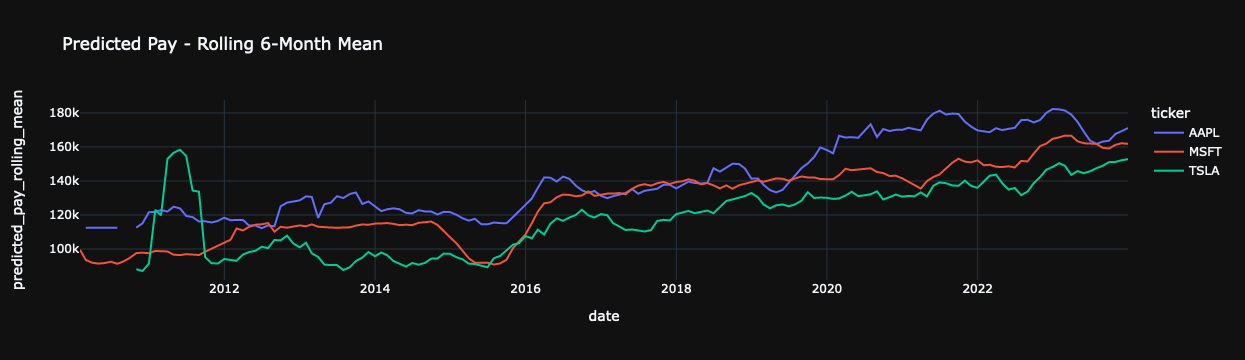

In [90]:
import pandas as pd
import plotly.express as px

# Filter for the 'AAPL' ticker
df_ticks = df_visa.groupby('ticker')['predicted_pay'].resample('M', level='date').mean(numeric_only=True)

# df_ticks_rolling = df_ticks.unstack().rolling(window=6, min_periods=1).mean(numeric_only=True).stack()

# Calculate the rolling 6-month mean
df_ticks_rolling = df_ticks.groupby(level=0).rolling(window=6, min_periods=1).mean()

df_ticks_rolling = df_ticks_rolling.droplevel(0)

df_ticks_rolling = df_ticks_rolling.reset_index()


df_ticks_rolling.columns = ['ticker', 'date', 'predicted_pay_rolling_mean']  # Assign the correct column name

# Create the time series plot with multiple lines
fig = px.line(df_ticks_rolling[["ticker", "date", "predicted_pay_rolling_mean"]], x='date', y='predicted_pay_rolling_mean', color='ticker', title='Predicted Pay - Rolling 6-Month Mean')

# Show the plot
fig.show()

In [133]:
import pandas as pd

# Assuming df_visa is already defined
# Calculate mean and count of predicted_pay for each group
grouped_data = df_visa.groupby(["soc_title", "ticker"]).agg(
    mean_predicted_pay=('predicted_pay', 'mean'),
    count=('predicted_pay', 'count')
)

# Sort by mean_predicted_pay and select the top 20
top_20 = grouped_data.sort_values(by='mean_predicted_pay', ascending=False).head(20)

print(top_20)


                                                  mean_predicted_pay  count
soc_title                                 ticker                           
chief executives                          TSLA            400000.000      1
general and operations managers           MSFT            256337.365     85
architectural and engineering managers    MSFT            238718.750     32
natural sciences managers                 AAPL            235000.000      7
advertising and promotions managers       MSFT            220820.000     16
public relations managers                 MSFT            218920.000     30
sales managers                            TSLA            217266.462     13
producers and directors                   AAPL            215000.000      1
meeting, convention, and event planners   AAPL            210000.000      8
financial managers                        AAPL            209540.177     62
                                          TSLA            201671.818     11
purchasing m

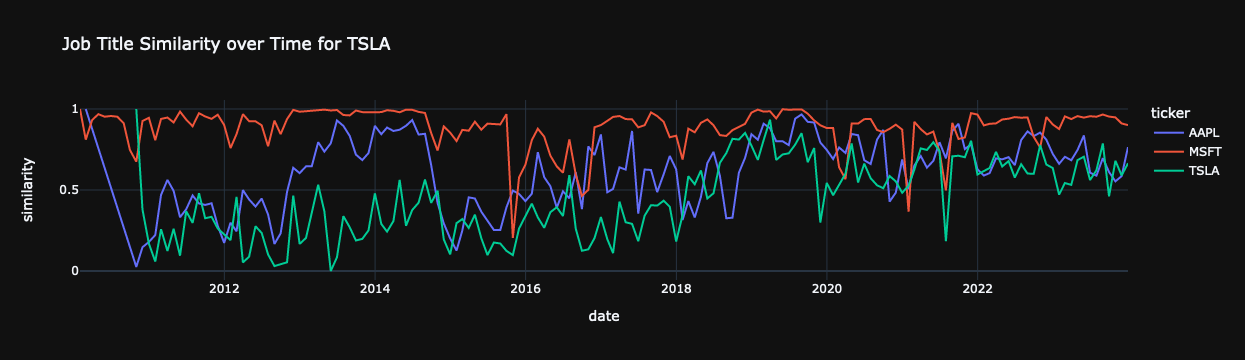

In [115]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import plotly.express as px

def preprocess_job_titles(job_titles):
    """Preprocess job titles by converting to lowercase and removing special characters"""
    job_titles = job_titles.str.lower()  # Convert to lowercase
    job_titles = job_titles.str.replace('[^a-zA-Z\s]', '', regex=True)  # Remove special characters
    return job_titles

def calculate_job_title_similarity(df, ticker):
    """Calculate the cosine similarity between job title vectors for consecutive time periods"""
    df = df[df['ticker'] == ticker]  # Filter for the given ticker
    df['job_title'] = preprocess_job_titles(df['job_title'])  # Preprocess job titles

    # Create TF-IDF vectors for job titles
    vectorizer = TfidfVectorizer()
    job_title_vectors = vectorizer.fit_transform(df['job_title'])

    # Group job title vectors by date and calculate the average vector for each time period
    avg_vectors = []
    dates = []
    for date, group in df.groupby(pd.Grouper(key='date', freq='M')):
        job_titles = group['job_title']
        if len(job_titles) > 0:
            group_vectors = job_title_vectors[job_titles.index]
            avg_vector = np.mean(group_vectors.toarray(), axis=0)  # Convert to dense array
            avg_vectors.append(avg_vector)
            dates.append(date)

    # Calculate the cosine similarity between consecutive time periods
    similarities = [1.0]  # Start with a similarity of 1.0
    for i in range(1, len(avg_vectors)):
        prev_vector = avg_vectors[i - 1]
        curr_vector = avg_vectors[i]
        similarity = cosine_similarity([prev_vector], [curr_vector])[0][0]
        similarities.append(similarity)

    # Create a DataFrame with dates and similarities
    similarity_df = pd.DataFrame({'date': dates, 'similarity': similarities})

    return similarity_df

# Filter for a specific ticker
ticker = 'AAPL'
df_visa_ri = df_visa.reset_index()

df = []
for ticker in df_visa_ri["ticker"].unique():
    aapl_data = df_visa_ri[df_visa_ri['ticker'] == ticker].reset_index(drop=True)
    # Calculate the job title similarity over time
    similarity_df = calculate_job_title_similarity(aapl_data, ticker)
    similarity_df["ticker"] = ticker
    df.append(similarity_df)

similarity_df = pd.concat(df,axis=0)

# Create a line plot to visualize the job title similarity over time
fig = px.line(similarity_df, x='date', y='similarity', color="ticker", title=f'Job Title Similarity over Time for {ticker}')
fig.show()

In [91]:
# !pip install bertopic

# from bertopic import BERTopic

# df_visa_ri = df_visa.reset_index().copy()

# # df_visa_ri = df_visa_ri[df_visa_ri["ticker"]=="AAPL"]

# timestamps = df_visa_ri.date.to_list()
# job_title = df_visa_ri.job_title.to_list()

# topic_model = BERTopic(verbose=True)
# topics, probs = topic_model.fit_transform(job_title)



# topics_over_time = topic_model.topics_over_time(job_title, timestamps, nr_bins=5)

# topic_model.visualize_topics_over_time(topics_over_time, top_n_topics=5)

predicted_pay          case_status  \
ticker date                                                      
AAPL   2010-02-25 17:38:06      90000.000  certified-withdrawn   
       2010-02-25 19:58:11     135000.000  certified-withdrawn   
       2010-10-02 00:00:00     120000.000            certified   
       2010-10-02 00:00:00     120000.000            certified   
       2010-10-04 00:00:00      92000.000            certified   
...                                   ...                  ...   
       2023-12-21 00:00:00     131500.000            certified   
       2023-12-21 00:00:00     131500.000            certified   
       2023-12-21 00:00:00     131500.000            certified   
       2023-12-21 00:00:00     131500.000            certified   
       2023-12-21 00:00:00     131500.000            certified   

                                   case_number        decision_date  \
ticker date                                                           
AAPL   2010-02-25 17:38:06  i-200-10056-419920  2013-08-01T17:48:30   
       2010-02-25 19:58:11  i-200-10056-978029  2013-01-11T20:32:49   
       2010-10-02 00:00:00  i-200-10273-447752  2010-10-07T00:00:00   
       2010-10-02 00:00:00  i-200-10273-447752  2010-10-07T00:00:00   
       2010-10-04 00:00:00  i-203-10275-388771  2010-10-08T00:00:00   
...                                        ...                  ...   
       2023-12-21 00:00:00  i-200-23355-585364  2023-12-29T00:00:00   
       2023-12-21 00:00:00  i-200-23355-585364  2023-12-29T00:00:00   
       2023-12-21 00:00:00  i-200-23355-585364  2023-12-29T00:00:00   
       2023-12-21 00:00:00  i-200-23355-585364  2023-12-29T00:00:00   
       2023-12-21 00:00:00  i-200-23355-585364  2023-12-29T00:00:00   

                                visa_class           begin_date  \
ticker date                                                       
AAPL   2010-02-25 17:38:06            h-1b  2010-08-24T00:00:00   
       2010-02-25 19:58:11            h-1b  2010-08-24T00:00:00   
       2010-10-02 00:00:00            h-1b  2010-10-11T00:00:00   
       2010-10-02 00:00:00            h-1b  2010-10-11T00:00:00   
       2010-10-04 00:00:00  e-3 australian  2011-03-23T00:00:00   
...                                    ...                  ...   
       2023-12-21 00:00:00            h-1b  2023-12-29T00:00:00   
       2023-12-21 00:00:00            h-1b  2023-12-29T00:00:00   
       2023-12-21 00:00:00            h-1b  2023-12-29T00:00:00   
       2023-12-21 00:00:00            h-1b  2023-12-29T00:00:00   
       2023-12-21 00:00:00            h-1b  2023-12-29T00:00:00   

                                       end_date employer_name  \
ticker date                                                     
AAPL   2010-02-25 17:38:06  2013-08-24T00:00:00    apple inc.   
       2010-02-25 19:58:11  2013-08-24T00:00:00    apple inc.   
       2010-10-02 00:00:00  2013-10-10T00:00:00    apple inc.   
       2010-10-02 00:00:00  2013-10-10T00:00:00    apple inc.   
       2010-10-04 00:00:00  2013-03-22T00:00:00    apple inc.   
...                                         ...           ...   
       2023-12-21 00:00:00  2026-12-28T00:00:00    apple inc.   
       2023-12-21 00:00:00  2026-12-28T00:00:00    apple inc.   
       2023-12-21 00:00:00  2026-12-28T00:00:00    apple inc.   
       2023-12-21 00:00:00  2026-12-28T00:00:00    apple inc.   
       2023-12-21 00:00:00  2026-12-28T00:00:00    apple inc.   

                                        employer_address1 employer_city  \
ticker date                                                               
AAPL   2010-02-25 17:38:06  one infinite loop, m/s 84-rel     cupertino   
       2010-02-25 19:58:11  one infinite loop, m/s 84-rel     cupertino   
       2010-10-02 00:00:00  one infinite loop, m/s 84-rel     cupertino   
       2010-10-02 00:00:00  one infinite loop, m/s 84-rel     cupertino   
       2010-10-04 00:00:00  one infinite loop, m/s 84-rel     cupertino   
..